# Transfer Learning with tensoflow Part 3: Scaling up (food vision mini)

We've seen the power of transfer learning feature extraction and fine-tuning, now it's time to scale up all of classes in Food101 (101 total classes of food).

Our goal is to beat the original Food101 paper with 10% of the training (leveraging the power of deep learning).

Original Food101 paper - https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf

Our baseline to beat is 50.76% accuracy across 101 classes.

In [1]:
# Check to see if we're using GPU
!nvidia-smi

Fri Jul  1 22:18:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.15       Driver Version: 512.15       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   45C    P8     5W /  N/A |   3073MiB /  4096MiB |      6%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Create helper functions

In [7]:
# Import Series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir, compare_historys

## 101 Food classes: Working with less data

Our goal is to beat the original Food101 paper with 10% of the training data, so let's download it.

The data we're downloading comes from the original Food101 dataset but has been preprocessed using the image_data_modification
notebook - https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb

In [5]:
# Download and unzip data - preprocessed from Food101
import urllib.request

url = 'https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip'
filename = '101_food_classes_10_percent.zip'

urllib.request.urlretrieve(url, filename)

#  unzip data
unzip_data(filename)

In [8]:
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [9]:
# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent\test'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\apple_pie'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\baby_back_ribs'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\baklava'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beef_carpaccio'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beef_tartare'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beet_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beignets'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\bibimbap'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\bread_pudding'.
There are 0 directories and 250 images in '10

There are 0 directories and 250 images in '101_food_classes_10_percent\test\spring_rolls'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\steak'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\strawberry_shortcake'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\sushi'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\tacos'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\takoyaki'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\tiramisu'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\tuna_tartare'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\waffles'.
There are 101 directories and 0 images in '101_food_classes_10_percent\train'.
There are 0 directories and 75 images in '101_food_classes_10_percent\train\apple_pie'.
There are 0 directories and 75 images in

In [10]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                               label_mode="categorical",
                                                                               image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                               label_mode="categorical",
                                                               image_size=IMG_SIZE,
                                                               shuffle=False) # dont's shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes

Here are the steps we're going to take:
* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layers) functional EfficientNetB0 backboned-model (we'll create our own output layer)
* Compile our model
* Feature extract for 5 full passes (5 epochs on the train dataset and validate on 15% of the test data, to save epoch time)

In [10]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                        save_weight_only=True,
                                                        monitor="val_accuracy",
                                                        save_best_only=True)

In [13]:
# create data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
#     preprocessing.Rescaling(1/255.) # rescale inputs of images to between 0 & 1, required for models like ResNetv2
], name="data_augmentation")

In [15]:
# Setup the base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# setup model architecture with trainable top layer
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs) # augment image (only happens during traing phase)
x = base_model(x, training=False) # put the base model in inference mode so weights which need to stay frozen.
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

In [16]:
# Get a summary of model we've created
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_avg_pool_layer (Globa (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [17]:
# Compile the model
model.compile(loss="categorical_crossentropy",
             optimizer=tf.keras.optimizers.Adam(),
             metrics=["accuracy"])

In [18]:
# Fit the model
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                          epochs=5,
                                          validation_data=test_data,
                                          validation_steps=int(0.15 * len(test_data)), # validate on only 15% of test data during training
                                          callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 98s 375ms/step - loss: 3.4685 - accuracy: 0.2477 - val_loss: 2.6963 - val_accuracy: 0.4031
INFO:tensorflow:Assets written to: 101_classes_10_percent_data_model_checkpoint\assets


C:\Users\LENOVO\miniconda3\envs\tensorflow\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/5
237/237 [==============================] - 67s 279ms/step - loss: 2.3412 - accuracy: 0.4653 - val_loss: 2.2943 - val_accuracy: 0.4447
INFO:tensorflow:Assets written to: 101_classes_10_percent_data_model_checkpoint\assets


C:\Users\LENOVO\miniconda3\envs\tensorflow\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/5
237/237 [==============================] - 64s 270ms/step - loss: 1.9674 - accuracy: 0.5314 - val_loss: 2.0820 - val_accuracy: 0.4764
INFO:tensorflow:Assets written to: 101_classes_10_percent_data_model_checkpoint\assets


C:\Users\LENOVO\miniconda3\envs\tensorflow\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 4/5
237/237 [==============================] - 78s 327ms/step - loss: 1.7569 - accuracy: 0.5764 - val_loss: 2.0575 - val_accuracy: 0.4730
Epoch 5/5
237/237 [==============================] - 72s 302ms/step - loss: 1.5923 - accuracy: 0.6103 - val_loss: 1.9579 - val_accuracy: 0.4934
INFO:tensorflow:Assets written to: 101_classes_10_percent_data_model_checkpoint\assets


C:\Users\LENOVO\miniconda3\envs\tensorflow\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [20]:
# Evaluuate on the whole test dataset
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 112s 141ms/step - loss: 1.7208 - accuracy: 0.5499


[1.720849633216858, 0.5499405860900879]

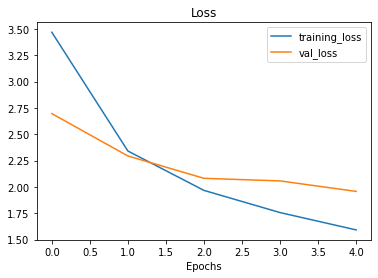

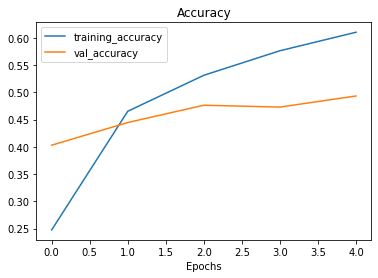

In [21]:
# Plot the loss curves
plot_loss_curves(history_all_classes_10_percent)

> **QUESTION:** what do these curves suggest? 

HINT: ideally, the two curves should be very similar to each other, it not it may suggest that our model in overfitting (performing too well on the training data and not generalizing to unseen data).

## Fine-tuning

In [22]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
    layer.trainable = False

In [24]:
# Recompile model with lower learing rate (it's typically best practice to lower the learning rate when fine-tuning)
model.compile(loss="categorical_crossentropy",
             optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # learning rate lowered by 10x
             metrics=["accuracy"])

In [25]:
# What layers in the model are trainable?
for layer in model.layers:
    print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [26]:
# Check which layers are trainable in our base model
for layer_number, layer in enumerate(model.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_2 False
1 rescaling_2 False
2 normalization_1 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [27]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10 # model has already done 5 epochs (feature extraction), this is the total number of epochs we're after (5 epochs)

# Fine-tune our model
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                         epochs=fine_tune_epochs,
                                         validation_data=test_data,
                                         validation_steps=int(0.15 * len(test_data)),
                                         initial_epoch=history_all_classes_10_percent.epoch[-1]) 

Epoch 5/10
237/237 [==============================] - 63s 237ms/step - loss: 1.3640 - accuracy: 0.6535 - val_loss: 1.9187 - val_accuracy: 0.5061
Epoch 6/10
237/237 [==============================] - 51s 215ms/step - loss: 1.2299 - accuracy: 0.6709 - val_loss: 1.8858 - val_accuracy: 0.5122
Epoch 7/10
237/237 [==============================] - 51s 216ms/step - loss: 1.1464 - accuracy: 0.6950 - val_loss: 1.8718 - val_accuracy: 0.5175
Epoch 8/10
237/237 [==============================] - 49s 206ms/step - loss: 1.0916 - accuracy: 0.7121 - val_loss: 1.8679 - val_accuracy: 0.5238
Epoch 9/10
237/237 [==============================] - 50s 209ms/step - loss: 1.0275 - accuracy: 0.7277 - val_loss: 1.8577 - val_accuracy: 0.5252
Epoch 10/10
237/237 [==============================] - 48s 201ms/step - loss: 0.9795 - accuracy: 0.7432 - val_loss: 1.8633 - val_accuracy: 0.5228


In [28]:
# Evaluate on the whole test data
all_classes_10_percent_fine_tuning_results = model.evaluate(test_data)
all_classes_10_percent_fine_tuning_results

790/790 [==============================] - 81s 103ms/step - loss: 1.6049 - accuracy: 0.5774


[1.6049392223358154, 0.5773861408233643]

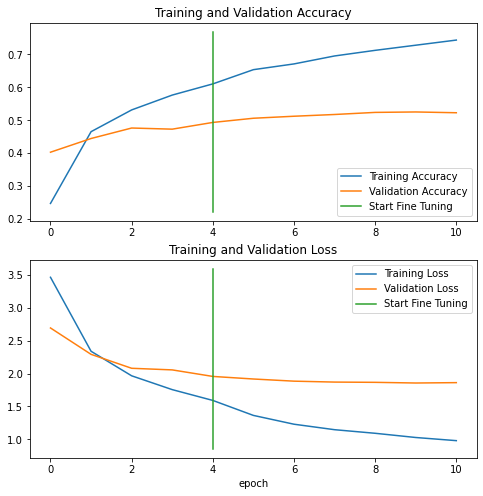

In [30]:
# Compare the histories of feature extraction model with fine-tuning model
compare_historys(original_history=history_all_classes_10_percent,
                new_history=history_all_classes_10_percent_fine_tune,
                initial_epochs=5)

## Saving and loading our model

To use our model in an external application, we'll need to save it and export it somewhere.

In [32]:
# Save our fine-tuning model
model.save("101_food_classes_10_percent_saved_big_dog_model")

INFO:tensorflow:Assets written to: 101_food_classes_10_percent_saved_big_dog_model\assets


C:\Users\LENOVO\miniconda3\envs\tensorflow\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [14]:
# Load an evaluate saved model
loaded_model = tf.keras.models.load_model("101_food_classes_10_percent_saved_big_dog_model")

In [15]:
# Evaluate loaded model and compare performance to pre-saved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 113s 126ms/step - loss: 1.6049 - accuracy: 0.5774


[1.6049392223358154, 0.5773861408233643]

In [37]:
# The results from our loaded_model (above) should be very similar to the results below
all_classes_10_percent_fine_tuning_results

[1.6049392223358154, 0.5773861408233643]

## Evaluating the performance of the big dog model across all diffrent classes

Let's make some predictions, visualize them and then later find out which predictions were the "most" wrong.

In [3]:
# Download pretrained model
import tensorflow as tf
import urllib.request

# url = 'https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip'
# filename = '06_101_food_class_10_percent_saved_big_dog_model.zip'

# urllib.request.urlretrieve(url, filename)

# #  unzip data
# unzip_data(filename)

In [40]:
!dir

 Volume in drive C is Windows-SSD
 Volume Serial Number is 9C4D-A4B5

 Directory of C:\Users\LENOVO\Desktop\tensorflow-deep-learning-101\06-transfer-learning-in-tensorflow-part-3-scaling-up

07/02/2022  10:00 AM    <DIR>          .
07/01/2022  09:49 PM    <DIR>          ..
07/01/2022  10:10 PM    <DIR>          .ipynb_checkpoints
07/02/2022  09:58 AM           160,027 06-transfer-learning-in-tensorflow-part-3-scaling-up.ipynb
07/02/2022  10:00 AM    <DIR>          06_101_food_class_10_percent_saved_big_dog_model
07/02/2022  10:00 AM        46,760,742 06_101_food_class_10_percent_saved_big_dog_model.zip
07/02/2022  08:37 AM    <DIR>          101_classes_10_percent_data_model_checkpoint
07/01/2022  10:28 PM    <DIR>          101_food_classes_10_percent
07/01/2022  10:28 PM     1,625,420,029 101_food_classes_10_percent.zip
07/02/2022  09:29 AM    <DIR>          101_food_classes_10_percent_saved_big_dog_model
06/30/2022  03:55 PM            10,677 helper_functions.py
07/02/2022  10:00 AM  

In [16]:
# Load in saved model
model = tf.keras.models.load_model("06_101_food_class_10_percent_saved_big_dog_model")

In [17]:
# Evaluate loaded model (the one we just downloaded on test data)
results_downloaded_model = model.evaluate(test_data)
results_downloaded_model

790/790 [==============================] - 104s 128ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027204275131226, 0.6077623963356018]

# Makiing predictions with our trained model

In [18]:
# make predictions with model
preds_probs = model.predict(test_data, verbose=1) # set verbosity to see how long is left

790/790 [==============================] - 81s 100ms/step


In [19]:
len(test_data), 790*32

(790, 25280)

In [20]:
# How many predictions are there?
len(preds_probs)

25250

In [21]:
# What's the shape of our predictions
preds_probs.shape

(25250, 101)

In [22]:
# Let's see what the first 10 predictions look like
preds_probs[:10]

array([[5.9542328e-02, 3.5742223e-06, 4.1377123e-02, ..., 1.4138722e-09,
        8.3530846e-05, 3.0897532e-03],
       [9.6401691e-01, 1.3753221e-09, 8.4780221e-04, ..., 5.4287157e-05,
        7.8362369e-12, 9.8466035e-10],
       [9.5925879e-01, 3.2533866e-05, 1.4866964e-03, ..., 7.1891623e-07,
        5.4397736e-07, 4.0276122e-05],
       ...,
       [4.7313276e-01, 1.2931163e-07, 1.4805584e-03, ..., 5.9750123e-04,
        6.6968991e-05, 2.3469349e-05],
       [4.4572055e-02, 4.7265306e-07, 1.2258509e-01, ..., 6.3498810e-06,
        7.5318590e-06, 3.6778662e-03],
       [7.2438937e-01, 1.9249764e-09, 5.2311072e-05, ..., 1.2291416e-03,
        1.5792830e-09, 9.6395626e-05]], dtype=float32)

In [23]:
# What does the first prediction probability array look like?
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

(array([5.9542328e-02, 3.5742223e-06, 4.1377123e-02, 1.0660627e-09,
        8.1614830e-09, 8.6639753e-09, 8.0927748e-07, 8.5653153e-07,
        1.9859093e-05, 8.0978077e-07, 3.1727898e-09, 9.8674229e-07,
        2.8532339e-04, 7.8049428e-10, 7.4230350e-04, 3.8916347e-05,
        6.4740689e-06, 2.4977426e-06, 3.7891285e-05, 2.0678350e-07,
        1.5538482e-05, 8.1507267e-07, 2.6230648e-06, 2.0010783e-07,
        8.3828104e-07, 5.4216093e-06, 3.7391148e-06, 1.3150623e-08,
        2.7761606e-03, 2.8052053e-05, 6.8562889e-10, 2.5575031e-05,
        1.6689009e-04, 7.6407081e-10, 4.0453052e-04, 1.3150723e-08,
        1.7957414e-06, 1.4448218e-06, 2.3062982e-02, 8.2466943e-07,
        8.5366270e-07, 1.7138647e-06, 7.0525775e-06, 1.8402222e-08,
        2.8553572e-07, 7.9483543e-06, 2.0681675e-06, 1.8525208e-07,
        3.3619678e-08, 3.1522600e-04, 1.0410934e-05, 8.5448863e-07,
        8.4741795e-01, 1.0555436e-05, 4.4095012e-07, 3.7404432e-05,
        3.5306231e-05, 3.2489042e-05, 6.7314817e

Our model outputs a prediction probability array ( with N number of variables, where N is the number of classes) for each sample passed to predict method.

In [24]:
# We get on prediction probability per class (in our case there's 101 prediction probability)
print(f"Number of prediction probabilities for sample 0: {len(preds_probs[0])}")
print(f"What prediction probabilities sample 0 look like:\n {preds_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {preds_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction probabilities sample 0 look like:
 [5.9542328e-02 3.5742223e-06 4.1377123e-02 1.0660627e-09 8.1614830e-09
 8.6639753e-09 8.0927748e-07 8.5653153e-07 1.9859093e-05 8.0978077e-07
 3.1727898e-09 9.8674229e-07 2.8532339e-04 7.8049428e-10 7.4230350e-04
 3.8916347e-05 6.4740689e-06 2.4977426e-06 3.7891285e-05 2.0678350e-07
 1.5538482e-05 8.1507267e-07 2.6230648e-06 2.0010783e-07 8.3828104e-07
 5.4216093e-06 3.7391148e-06 1.3150623e-08 2.7761606e-03 2.8052053e-05
 6.8562889e-10 2.5575031e-05 1.6689009e-04 7.6407081e-10 4.0453052e-04
 1.3150723e-08 1.7957414e-06 1.4448218e-06 2.3062982e-02 8.2466943e-07
 8.5366270e-07 1.7138647e-06 7.0525775e-06 1.8402222e-08 2.8553572e-07
 7.9483543e-06 2.0681675e-06 1.8525208e-07 3.3619678e-08 3.1522600e-04
 1.0410934e-05 8.5448863e-07 8.4741795e-01 1.0555436e-05 4.4095012e-07
 3.7404432e-05 3.5306231e-05 3.2489042e-05 6.7314817e-05 1.2852656e-08
 2.6219887e-10 1.0318120e-05 8.5744294e-05 1

In [25]:
test_data.class_names[52]

'gyoza'

In [26]:
# Get the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)

# How do they look ?
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0], dtype=int64)

In [27]:
# how many pred classes do we have ?
len(pred_classes)

25250

Now we've got a predictions array of all of our model's predictions, to evaluate them, we need to compare them to the original test dataset labels.

In [28]:
# To get our test labels we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
    y_labels.append(labels.numpy().argmax()) # currently test labels looke like: [0, 0, 0, 1, ... 0, 0], we want the index value

y_labels[:10] # Look at the first 10

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [29]:
# How many y_labels are there ?
len(y_labels)

25250

In [30]:
test_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 101)), types: (tf.float32, tf.float32)>

In [31]:
len(test_data)

790

## Evaluating our Model's predictions

One way to check that our model's predictions array is in the same order as our test labels array is to find the  accuray score.

In [32]:
results_downloaded_model

[1.8027204275131226, 0.6077623963356018]

In [33]:
# let's try scikit-learn's accuracy score function and see what it comes up with
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_labels,
                                 y_pred=pred_classes)

sklearn_accuracy

0.6077623762376237

In [34]:
# Does this metric come close to our model's evaluate results
import numpy as np
np.isclose(results_downloaded_model[1], sklearn_accuracy)

True

## Let's get visual: making confusion matrix


In [35]:
from helper_functions import make_confusion_matrix

In [36]:
# Get a list of class names
class_names = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [37]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# We need to make some changes to our make_confusion_matrix function to ensure the x-labels print vertically
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Change (plot x-labels vertically) ###
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)
    
  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

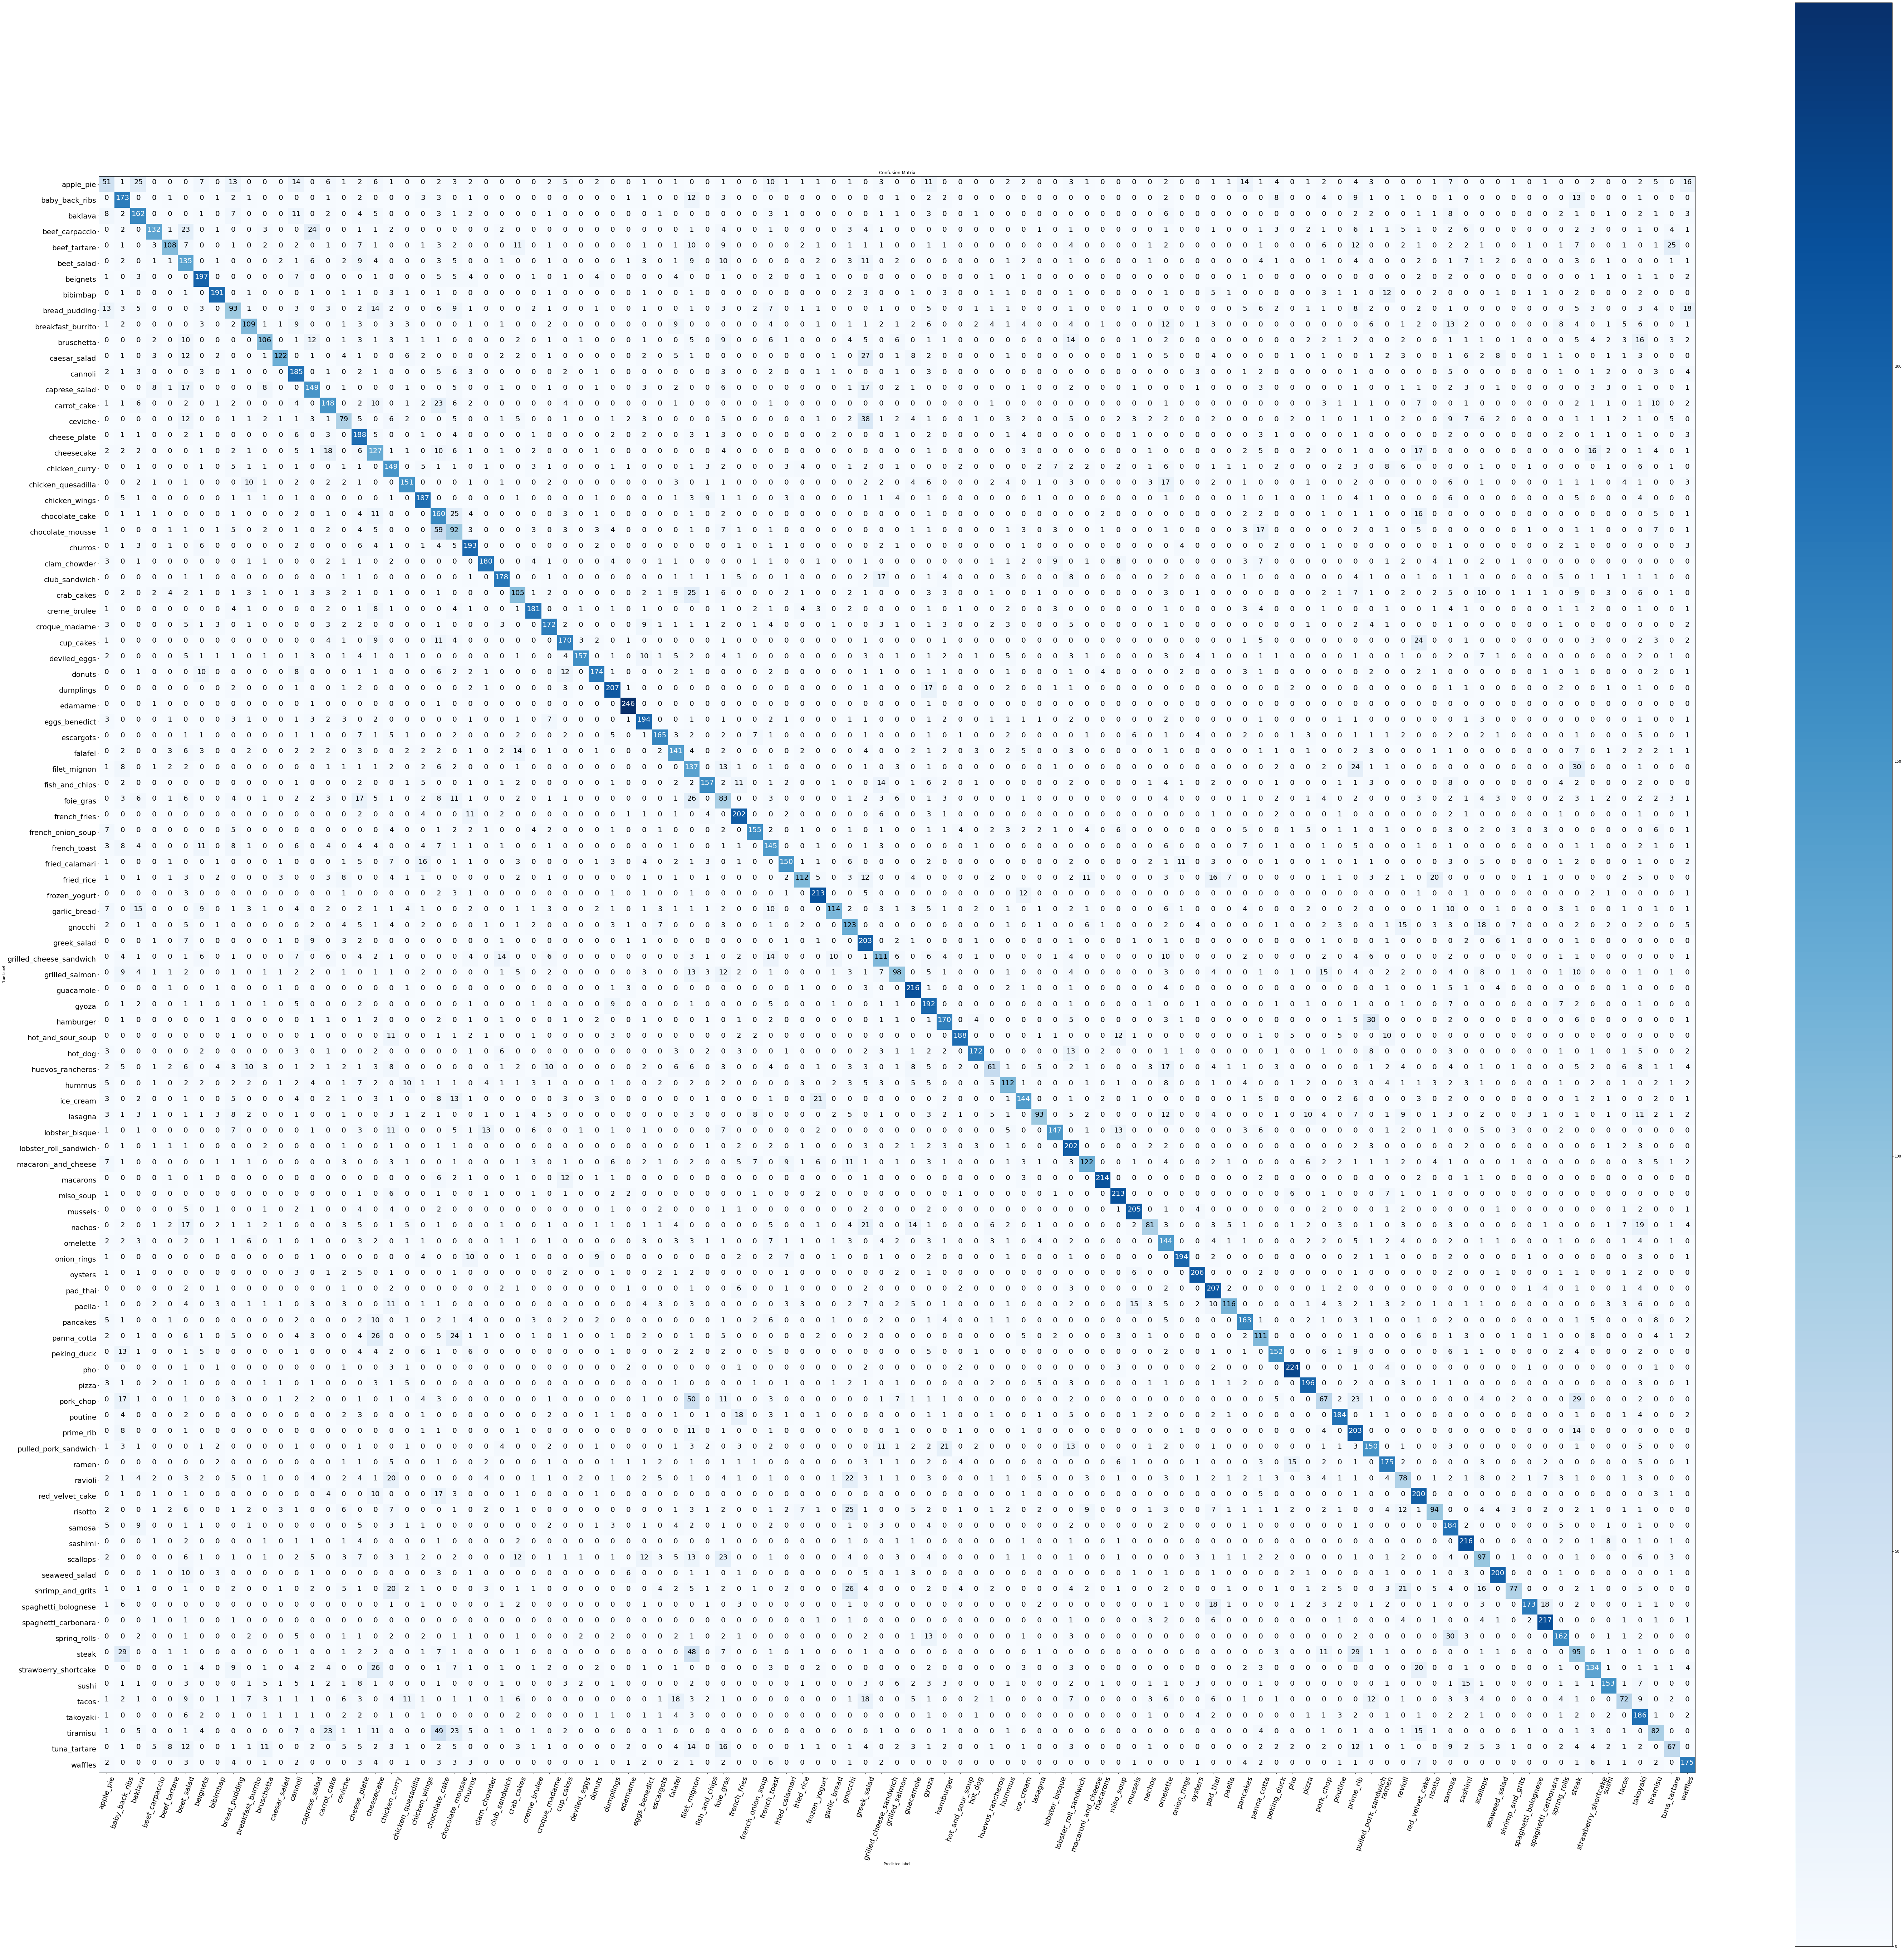

In [38]:
make_confusion_matrix(y_true=y_labels,
                     y_pred=pred_classes,
                     classes=class_names,
                     figsize=(100, 100),
                     text_size=20,
                     savefig=True)

## Let's keep the evaluation train going, time for a classification report

Scikit-Learn has a helpful function for acquiring many different classification metrics per class (e.g. precision, recall and F1) called [classification report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#examples-using-sklearn-metrics-classification-report)

In [39]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                           y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

The numbers above give a great class-by-class evaluation of our model's predicions but with so many classes, they're quite hard to understand.

How about we create a visualization to get a better understanding?

In [41]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.29310344827586204,
  'recall': 0.204,
  'f1-score': 0.24056603773584903,
  'support': 250},
 '1': {'precision': 0.5088235294117647,
  'recall': 0.692,
  'f1-score': 0.5864406779661017,
  'support': 250},
 '2': {'precision': 0.5625,
  'recall': 0.648,
  'f1-score': 0.6022304832713754,
  'support': 250},
 '3': {'precision': 0.7415730337078652,
  'recall': 0.528,
  'f1-score': 0.616822429906542,
  'support': 250},
 '4': {'precision': 0.7346938775510204,
  'recall': 0.432,
  'f1-score': 0.544080604534005,
  'support': 250},
 '5': {'precision': 0.34177215189873417,
  'recall': 0.54,
  'f1-score': 0.41860465116279066,
  'support': 250},
 '6': {'precision': 0.6677966101694915,
  'recall': 0.788,
  'f1-score': 0.7229357798165138,
  'support': 250},
 '7': {'precision': 0.8197424892703863,
  'recall': 0.764,
  'f1-score': 0.7908902691511386,
  'support': 250},
 '8': {'precision': 0.4025974025974026,
  'recall': 0.372,
  'f1-score': 0.3866943866943867,
  'support': 250},
 '9

In [42]:
class_names[70]

'pad_thai'

Let's plot all of our classes F1 scores...

In [43]:
class_names[98]

'tiramisu'

In [45]:
classification_report_dict["99"]["f1-score"]

0.35356200527704484

In [47]:
# Create empty dictionary
class_f1_scores = {}

# Loop through classification report dictionary items
for k, v in classification_report_dict.items():
    if k == "accuracy": # stop once we get to accuracy key
        break
    else:
        # Add class names and F1-scores to new dictionary
        class_f1_scores[class_names[int(k)]] = v["f1-score"]

class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [48]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                         "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)

In [50]:
f1_scores[:10]

class_names  f1-score
33              edamame  0.937143
63             macarons  0.895397
75                  pho  0.866538
91  spaghetti_carbonara  0.847656
69              oysters  0.834008
68          onion_rings  0.832618
65              mussels  0.820000
88        seaweed_salad  0.813008
64            miso_soup  0.812977
45        frozen_yogurt  0.811429

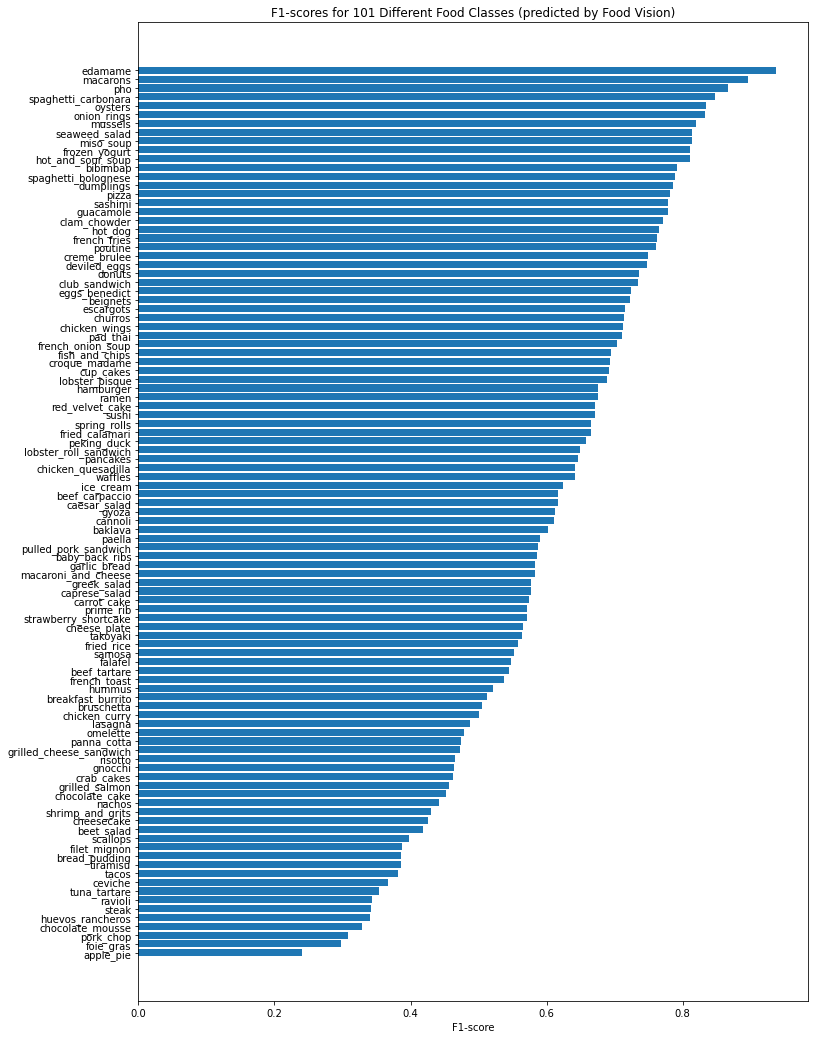

In [59]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 18))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values) # get f1-scores values
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1-scores for 101 Different Food Classes (predicted by Food Vision)")
ax.invert_yaxis(); # reverse the order of our plot

https://matplotlib.org/2.0.2/examples/api/barchart_demo.html

## Visualizing predictions on custom dataset

Now, this is the real test, how does our model go on food images not even in our test dataset (images of our own, we'll see this later on).

To visualize our model's predictions on our own images, we'll need a function to load and preprocess images, specifically it will need to:
* Read in a target image filepath using tf.io.read_file()
* Turn the image into a Tensor using tf.io.decode_image()
* Resize the image tensor to be the same size as the images our model has trained on using tf.image.resize()
* Scale the image to get all of the pixel values between 0 & 1 (if necessary )

In [76]:
# Create the fucntion to load and prepare images
def load_and_prep_image(filename, img_shape=224, scale=True):
    """
    Reads in an image from filename, turns it into a tensor and reshapes into spcified shape (img_shape, img_shape, color_channels=3).
    
    Args:
        filename (str): path to target image
        image_shape (int): height/width dimension of target image size
        scale (bool): scale pixel values from 0-255 to 0-1 or not
    
    Returns:
        Image tensor of shape (img_shape, img_shape, 3)
    """
    
    # Read in the image
    img = tf.io.read_file(filename)
    
    # Decode image into tensor
    img = tf.io.decode_image(img)
    
    # Resize the image
    img = tf.image.resize(img, [img_shape, img_shape])
    
    # Scale ? Yes/no
    if scale:
        # rescale the image (get all values between 0 and 1)
        return img/255.
    else:
        return img # don't need to rescale imges for EfficientNet models in TensorFlow

Now we've go a function to load and prepare target images let's now write some code visualize images, their target label and our model's predictions.

Specifically, we'll write some code to:
1. Load a few random images from the test dataset
2. Make predictions on the loaded images
3. Plot the original images along with the model's predictions, prediction probability and truth label

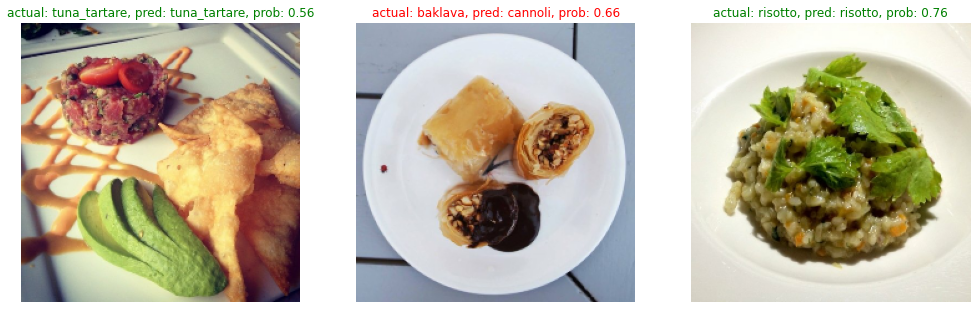

In [92]:
# make preds on a series of random images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
    # Choose a random image form a random class
    class_name = random.choice(class_names)
    filename = random.choice(os.listdir(test_dir + "/" + class_name))
    filepath = test_dir + class_name + "/" + filename
#     print(filepath)
    
    # Load the image and make predictions
    img = load_and_prep_image(filepath, scale=False)
    img_expanded = tf.expand_dims(img, axis=0)
#     print(img_expanded)
    pred_prob = model.predict(img_expanded) # get prediction probabilities array  and model accepts tensors of shape [None, 224, 224, 3]
    pred_class = class_names[pred_prob.argmax()] # get highest prediction probability index and match it class_names list
#     print(pred_prob)
#     print(pred_class)
    
    # Plot the images
    plt.subplot(1, 3, i+1)
#     print(img)
    plt.imshow(img/255.)
    if class_name == pred_class: # if predicted class matches truth class, make text green
        title_color = "g"
    else:
        title_color = "r"
    plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
    plt.axis(False)

In [63]:
test_dir

'101_food_classes_10_percent/test/'

In [61]:
import random
random.choice(class_names)

'chicken_quesadilla'

In [64]:
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

## Finding the most wrong predictions

To fine out where our model is most wrong, let's write some code to find out the following:
1. Get all of the image file paths in the test dataset using [list_file()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#list_files) method
2. Create a pandas DataFrame of the image filepaths, ground truth labels, predicted classes (from our model), max prediction probabilities, prediction class names and ground truth class name.
3. Use our DataFrame to find all the wrong predictions (where the ground truth label doesn't match the prediciton).
4. Sort the DataFrame based on wrong predictions (have the highest prediction probability predictions at the top).
5. Visualize the images with the highest prediction probabilities but have the wrong prediction.

In [93]:
# Get all of the image file path in the test dataset
filepaths = []
for filepath in test_data.list_files("101_food_classes_10_percent/test/*/*.jpg", shuffle=False):
    filepaths.append(filepath)
filepaths[:10]


[<tf.Tensor: shape=(), dtype=string, numpy=b'101_food_classes_10_percent\\test\\apple_pie\\1011328.jpg'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'101_food_classes_10_percent\\test\\apple_pie\\101251.jpg'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'101_food_classes_10_percent\\test\\apple_pie\\1034399.jpg'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'101_food_classes_10_percent\\test\\apple_pie\\103801.jpg'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'101_food_classes_10_percent\\test\\apple_pie\\1038694.jpg'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'101_food_classes_10_percent\\test\\apple_pie\\1047447.jpg'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'101_food_classes_10_percent\\test\\apple_pie\\1068632.jpg'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'101_food_classes_10_percent\\test\\apple_pie\\110043.jpg'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'101_food_classes_10_percent\\test\\apple_pie\\1106961.jpg'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'101_

In [97]:
# 2. Create a DataFrame of different parameters for each of our test images
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                       "y_true": y_labels,
                       "y_pred": pred_classes,
                       "pred_conf": preds_probs.max(axis=1),
                       "y_true_classname": [class_names[i] for i in y_labels],
                       "y_pred_classname": [class_names[i] for i in pred_classes]})
pred_df

img_path  y_true  y_pred  \
0      tf.Tensor(b'101_food_classes_10_percent\\test\...       0      52   
1      tf.Tensor(b'101_food_classes_10_percent\\test\...       0       0   
2      tf.Tensor(b'101_food_classes_10_percent\\test\...       0       0   
3      tf.Tensor(b'101_food_classes_10_percent\\test\...       0      80   
4      tf.Tensor(b'101_food_classes_10_percent\\test\...       0      79   
...                                                  ...     ...     ...   
25245  tf.Tensor(b'101_food_classes_10_percent\\test\...     100     100   
25246  tf.Tensor(b'101_food_classes_10_percent\\test\...     100      16   
25247  tf.Tensor(b'101_food_classes_10_percent\\test\...     100     100   
25248  tf.Tensor(b'101_food_classes_10_percent\\test\...     100      94   
25249  tf.Tensor(b'101_food_classes_10_percent\\test\...     100     100   

       pred_conf y_true_classname      y_pred_classname  
0       0.847418        apple_pie                 gyoza  
1       0.964017        apple_pie             apple_pie  
2       0.959259        apple_pie             apple_pie  
3       0.658607        apple_pie  pulled_pork_sandwich  
4       0.367902        apple_pie             prime_rib  
...          ...              ...                   ...  
25245   0.972823          waffles               waffles  
25246   0.878027          waffles          cheese_plate  
25247   0.537899          waffles               waffles  
25248   0.501950          waffles  strawberry_shortcake  
25249   0.690629          waffles               waffles  

[25250 rows x 6 columns]

In [94]:
[class_names[i] for i in y_labels[:10]]

['apple_pie',
 'apple_pie',
 'apple_pie',
 'apple_pie',
 'apple_pie',
 'apple_pie',
 'apple_pie',
 'apple_pie',
 'apple_pie',
 'apple_pie']

In [95]:
[class_names[i] for i in pred_classes[:10]]

['gyoza',
 'apple_pie',
 'apple_pie',
 'pulled_pork_sandwich',
 'prime_rib',
 'lobster_roll_sandwich',
 'cup_cakes',
 'apple_pie',
 'samosa',
 'apple_pie']

In [98]:
# 3. Find out in our DataFrame which predictions are wrong
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

img_path  y_true  y_pred  \
0  tf.Tensor(b'101_food_classes_10_percent\\test\...       0      52   
1  tf.Tensor(b'101_food_classes_10_percent\\test\...       0       0   
2  tf.Tensor(b'101_food_classes_10_percent\\test\...       0       0   
3  tf.Tensor(b'101_food_classes_10_percent\\test\...       0      80   
4  tf.Tensor(b'101_food_classes_10_percent\\test\...       0      79   

   pred_conf y_true_classname      y_pred_classname  pred_correct  
0   0.847418        apple_pie                 gyoza         False  
1   0.964017        apple_pie             apple_pie          True  
2   0.959259        apple_pie             apple_pie          True  
3   0.658607        apple_pie  pulled_pork_sandwich         False  
4   0.367902        apple_pie             prime_rib         False

In [102]:
# 4. Sort our DataFrame to have most wrong predictions at the top
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(10)

img_path  y_true  y_pred  \
21810  tf.Tensor(b'101_food_classes_10_percent\\test\...      87      29   
231    tf.Tensor(b'101_food_classes_10_percent\\test\...       0     100   
15359  tf.Tensor(b'101_food_classes_10_percent\\test\...      61      53   
23539  tf.Tensor(b'101_food_classes_10_percent\\test\...      94      83   
21400  tf.Tensor(b'101_food_classes_10_percent\\test\...      85      92   
24540  tf.Tensor(b'101_food_classes_10_percent\\test\...      98      83   
2511   tf.Tensor(b'101_food_classes_10_percent\\test\...      10      61   
5574   tf.Tensor(b'101_food_classes_10_percent\\test\...      22      21   
17855  tf.Tensor(b'101_food_classes_10_percent\\test\...      71      65   
23797  tf.Tensor(b'101_food_classes_10_percent\\test\...      95      86   

       pred_conf       y_true_classname       y_pred_classname  pred_correct  
21810   0.999997               scallops              cup_cakes         False  
231     0.999995              apple_pie                waffles         False  
15359   0.999988  lobster_roll_sandwich              hamburger         False  
23539   0.999987   strawberry_shortcake        red_velvet_cake         False  
21400   0.999981                 samosa           spring_rolls         False  
24540   0.999947               tiramisu        red_velvet_cake         False  
2511    0.999945             bruschetta  lobster_roll_sandwich         False  
5574    0.999939       chocolate_mousse         chocolate_cake         False  
17855   0.999931                 paella                mussels         False  
23797   0.999904                  sushi                sashimi         False

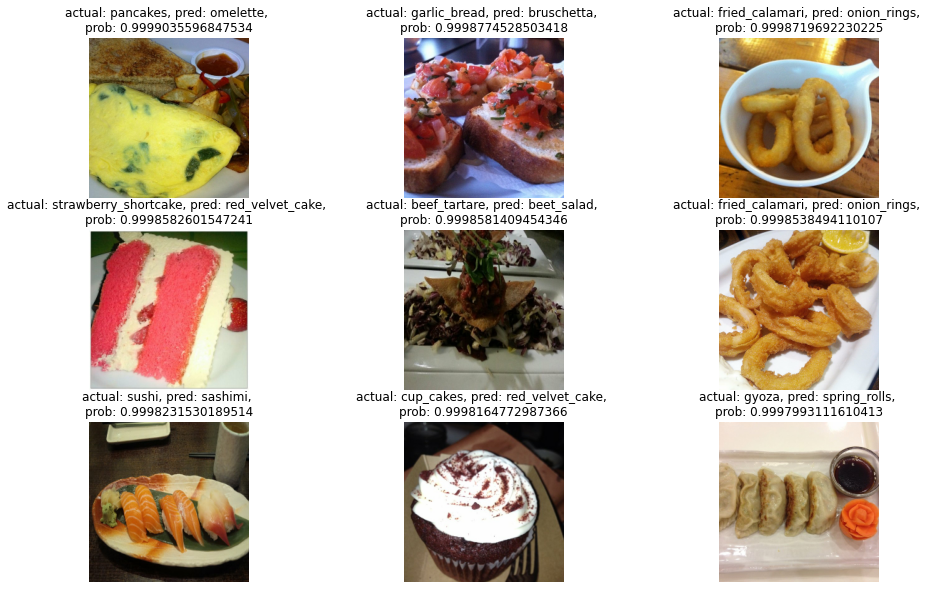

In [110]:
# 5. Visualize the test data samples which have the wrong prediction but highest pred probability
images_to_view = 9
start_index = 10
plt.figure(figsize=(16, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
#     print(row)
    plt.subplot(3, 3, i+1)
    img = load_and_prep_image(row[1], scale=False)
    _, _, _, _, pred_prob, y_true_classname, y_pred_classname, _ = row # only interested in a few parameters of each row
    plt.imshow(img/255.)
    plt.title(f"actual: {y_true_classname}, pred: {y_pred_classname}, \nprob: {pred_prob}")
    plt.axis(False)

## Test out the big dog model on our own custom images


In [111]:
import urllib.request
url = "https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip"

filename = 'custom_food_images.zip'

urllib.request.urlretrieve(url, filename)

#  unzip data
unzip_data(filename)

In [112]:
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/chicken_wings.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/sushi.jpeg']

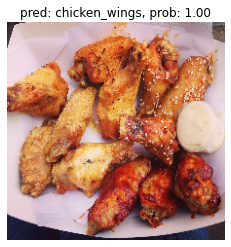

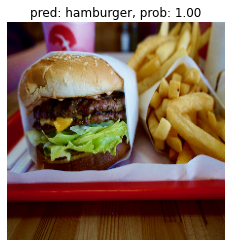

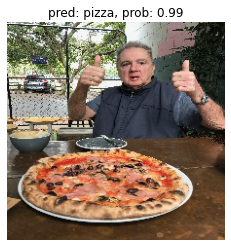

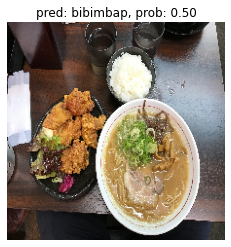

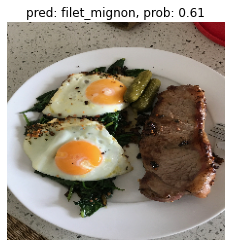

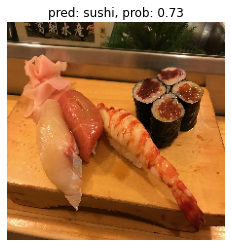

In [116]:
# Make predictions on and plot custom food images
for img in custom_food_images:
    img = load_and_prep_image(img, scale=False) # don't need to scale for our  EfficientNet 
    pred_prob = model.predict(tf.expand_dims(img, axis=0)) # make prediction on image
    pred_class = class_names[pred_prob.argmax()]
    # plot the appropriate information
    plt.figure()
    plt.imshow(img/255.)
    plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
    plt.axis(False)